In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import math
import operator
%matplotlib inline
from scipy.optimize import curve_fit
plt.style.use('grayscale')
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from matplotlib.font_manager import FontProperties
font0 = FontProperties()
def gen_font(weight, size):
    font1=font0.copy()
    font1.set_family('sans-serif')
    font1.set_weight(weight)
    font1.set_size(size)
    return font1

In [12]:
data = pd.read_csv('/Users/ozymandias/desktop/experiment_results/speed_data/0latency_data.csv')
test = pd.read_csv('/Users/ozymandias/desktop/experiment_results/speed_data/0latency_k80_test.csv')
data = shuffle(data, random_state=0)
test = shuffle(test, random_state=0)
# print data
data.set_index(["GPU (temp)"], inplace=True)

In [13]:
k80 = data.loc['K80']
p100 = data.loc['P100']

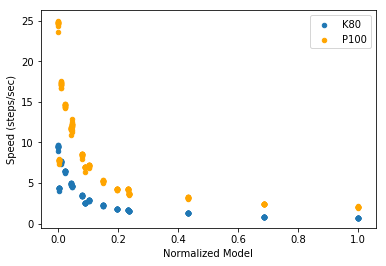

In [7]:
fig, ax = plt.subplots()
ax = k80.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='K80')
ax = p100.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='P100',color='orange')

Text(0.5,0,'Normalized Model FLOPS/GPU FLOPs')

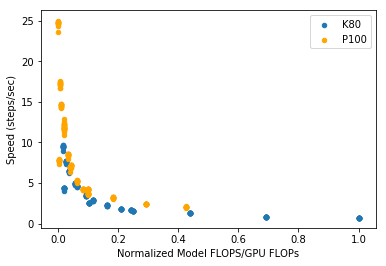

In [122]:
fig, ax = plt.subplots()
ax = k80.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='K80')
ax = p100.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='P100',color='orange')
plt.xlabel("Normalized Model FLOPS/GPU FLOPs")

[ 2.08650401 14.46575274 29.84611034]
[[ 0.04204517 -0.02786923  0.23311659]
 [-0.02786923  0.17562051  0.24197893]
 [ 0.23311659  0.24197893  3.71368925]]


<Figure size 432x288 with 0 Axes>

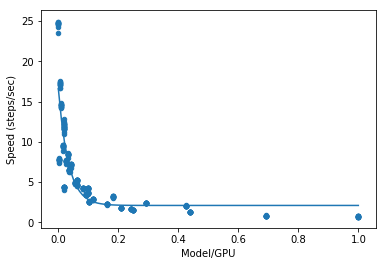

In [123]:
# def fitFunc(t, B, k):
#     return B*np.exp(-k*t)
# def fitFunc(t, k):
#     return k*np.exp(-k*t)
# def fitFunc(t, a, k):
#     return a + k*np.exp(-k*t)
def fitFunc(t, a, j, k):
    return a + j*np.exp(-k*t)
# popt, pcov = curve_fit(fitFunc,  k80["Model/GPU"],  k80['Speed (steps/sec)'], p0=(8))
# popt, pcov = curve_fit(fitFunc,  p100["Model/GPU"],  p100['Speed (steps/sec)'], p0=(16))
popt, pcov = curve_fit(fitFunc,  data["Model/GPU"],  data['Speed (steps/sec)'], maxfev=100000)
### (0.4, 15)
print popt
print pcov
plt.figure()
xx = np.linspace(0, 1, 100)
# yy = popt[0] + popt[1] * np.exp(-popt[1] * xx)
yy = popt[0] + popt[1] * np.exp(-popt[2] * xx)
fig, ax = plt.subplots()
plt.plot(xx, yy)
plt.xlabel('$x$')
plt.ylabel('$\exp(x)$')
# ax = k80.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='K80')
# ax = p100.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='P100',color='orange')
ax = data.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU")

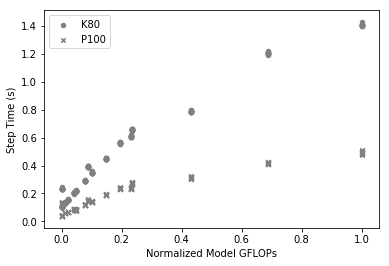

In [19]:
fig, ax = plt.subplots()
ax = k80.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model", label='K80',marker='o')
ax = p100.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model", label='P100',marker='x')
plt.xlabel('Normalized Model GFLOPs')
fig.savefig("/Users/ozymandias/Desktop/figure_4.pdf", bbox_inches='tight')

[ 0.14847741  2.08973939 -0.83795924]
[[ 2.61753355e-05 -1.49425947e-04  1.32004093e-04]
 [-1.49425947e-04  1.65269457e-03 -1.66542859e-03]
 [ 1.32004093e-04 -1.66542859e-03  1.83840535e-03]]


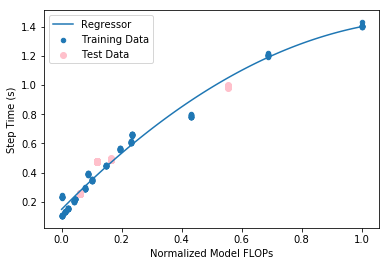

In [24]:
# def l( x, a, b, c, d ):
#     return a*np.log( b*x + c ) + d
def func(x, a, b, c):
    return a + b * x + c * x**2
popt, pcov = curve_fit(func,  k80["Normalized Model"],  k80['Step Time (s)'], maxfev=100000)
print popt
print pcov
fig, ax = plt.subplots()
xx = np.linspace(0, 1, 100)
yy =  popt[0] + popt[1] * xx + popt[2] * xx**2
X_test = test[['Normalized Model']]
y_test = test[['Step Time (s)']]
plt.plot(xx, yy, label="Regressor")
plt.xlabel('$x$')
plt.ylabel('$\exp(x)$')
k80.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model", label="Training Data")
ax.scatter(X_test, y_test, color='pink', label="Test Data")
plt.legend()
plt.xlabel("Normalized Model FLOPs")
plt.show()

Text(0,0.5,'Error %')

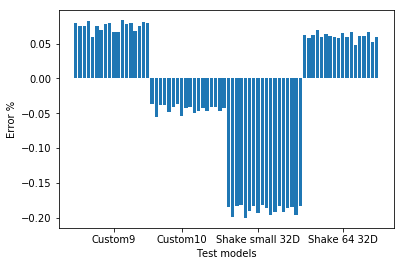

In [7]:
yy = []
for i in range(len(X_test.values)):
    yy.append(func(X_test.values[i][0], popt[0], popt[1], popt[2]))
err = []
err2 = []
tot = 0
for i in range(len(yy)):
    err.append(((yy[i] - y_test.values[i])**2)[0])
    err2.append((((yy[i] - y_test.values[i]))/y_test.values[i])[0])
    tot += ((yy[i] - y_test.values[i])**2)[0]
mse = tot/len(yy)
fig, ax = plt.subplots()
ax.bar(np.arange(72), err2)
lables = ['Custom9', 'Custom10', 'Shake small 32D', 'Shake 64 32D']
plt.xticks([9,25,43,63], lables)
plt.xlabel("Test models")
plt.ylabel("Error %")

In [20]:
X = k80[['Normalized Model']]
y = k80[['Step Time (s)']].values.ravel()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test = test[['Normalized Model']]
y_test = test[['Step Time (s)']]
xx = []
for i in range(len(X)):
    xx.append(X.values[i][0])
# svr = SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=0.01, coef0=1)
svr = SVR(kernel='rbf', C=100, gamma='auto', epsilon=0.04)
# svr = SVR(kernel='linear', C=100, gamma='auto', epsilon=0.1)
# svr.fit(X_train, y_train)
svr.fit(X, y)
scores = cross_val_score(svr, X, y, cv=10, scoring='neg_mean_squared_error')
print svr.get_params()
print scores
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(svr, X, y, cv=10, scoring='r2')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

{'kernel': 'rbf', 'C': 100, 'verbose': False, 'degree': 3, 'epsilon': 0.04, 'shrinking': True, 'max_iter': -1, 'tol': 0.001, 'cache_size': 200, 'coef0': 0.0, 'gamma': 'auto'}
[-0.00323073 -0.00238517 -0.00133108 -0.00155808 -0.002365   -0.00145616
 -0.00110445 -0.00203139 -0.00138663 -0.00128754]
Accuracy: -0.002 (+/- 0.001)
[0.97107076 0.98123098 0.97952194 0.98968175 0.98803738 0.98915132
 0.99011746 0.97926273 0.99281227 0.98855053]
Accuracy: 0.98 (+/- 0.01)


In [11]:
y_pred = svr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 0.027702883319287434)
('Mean Squared Error:', 0.0012900997360749756)
('Root Mean Squared Error:', 0.03591795840627604)


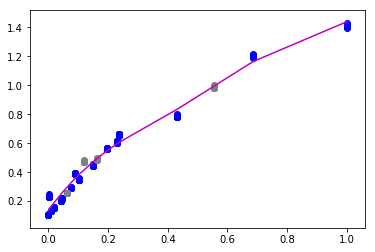

In [56]:
pred = svr.predict(X)
fig, ax = plt.subplots()
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(xx,pred), key=sort_axis)
xx, pred = zip(*sorted_zip)
plt.plot(xx, pred,color='m')
# ax.plot(X, svr.fit(X, y).predict(X), linestyle='-',label="Regressor")
ax.scatter(X, y, color='b', label="Training data")
ax.scatter(X_test, y_test, color='gray', label="Test data")

[-0.00280186 -0.0031776  -0.00117622 -0.00226118 -0.00323107 -0.00135635
 -0.00109613 -0.00342234 -0.00136347 -0.00276209]
Accuracy: -0.002 (+/- 0.002)
[0.97491103 0.97499539 0.98190434 0.98502552 0.98365661 0.98989493
 0.99019191 0.96506341 0.99293234 0.97543816]
Accuracy: 0.98 (+/- 0.02)


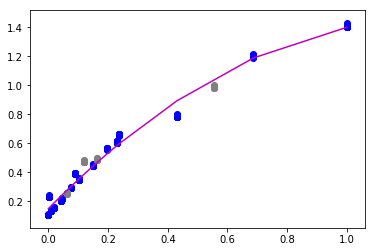

In [21]:
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X)
x_test_poly = polynomial_features.fit_transform(X_test)
regressor = LinearRegression()
regressor.fit(x_poly, y)
scores = cross_val_score(regressor, x_poly, y, cv=10, scoring='neg_mean_squared_error')
print scores
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(regressor, x_poly, y, cv=10, scoring='r2')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
fig, ax = plt.subplots()
y_poly_pred = regressor.predict(x_poly)
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(xx,y_poly_pred), key=sort_axis)
xx, y_poly_pred = zip(*sorted_zip)
plt.plot(xx, y_poly_pred, color='m')
ax.scatter(X, y, color='b', label="Training data")
ax.scatter(X_test, y_test, color='gray', label="Test data")
# ax.plot(x_poly, regressor.fit(x_poly, y).predict(x_poly), label="Regressor")
plt.show()

In [19]:
y_pred = regressor.predict(x_test_poly)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 0.0475573545986425)
('Mean Squared Error:', 0.0031245999243386057)
('Root Mean Squared Error:', 0.05589812093745733)


Text(0.5,0,'Normalized Model FLOPS/GPU FLOPs')

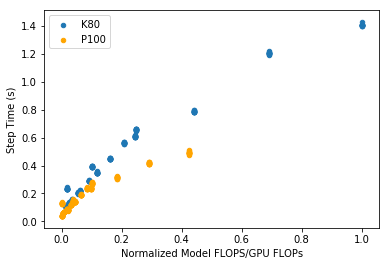

In [41]:
fig, ax = plt.subplots()
ax = k80.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='K80')
ax = p100.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='P100',color='orange')
plt.xlabel("Normalized Model FLOPS/GPU FLOPs")

In [92]:
data2 = pd.read_csv('/Users/ozymandias/desktop/experiment_results/speed_data/0latency_data.csv')
data2.set_index(["Model (temp)"], inplace=True)
res15 = data2.loc['Res15']
res32 = data2.loc['Res32']
shakesmall = data2.loc['shakesmall']
shakebig = data2.loc['shakebig']
shakemid = data2.loc['shakemid']
cus1 = data2.loc['custom1']
cus2 = data2.loc['custom2']
cus3 = data2.loc['custom3']
cus4 = data2.loc['custom4']
cus5 = data2.loc['custom5']
cus6 = data2.loc['custom6']
cus7 = data2.loc['custom7']
cus8 = data2.loc['custom8']
shake16 = data2.loc['shake16']
shake48 = data2.loc['shake48']
shake80 = data2.loc['shake80']

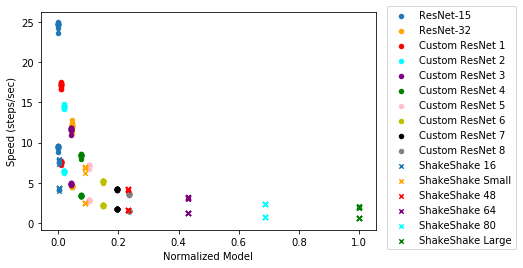

In [93]:
fig, ax = plt.subplots()
ax = res15.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='ResNet-15')
ax = res32.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='ResNet-32',color='orange')
ax = cus1.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='Custom ResNet 1',color='red')
ax = cus2.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='Custom ResNet 2',color='cyan')
ax = cus3.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='Custom ResNet 3',color='purple')
ax = cus4.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='Custom ResNet 4',color='g')
ax = cus5.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='Custom ResNet 5',color='pink')
ax = cus6.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='Custom ResNet 6',color='y')
ax = cus7.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='Custom ResNet 7',color='k')
ax = cus8.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='Custom ResNet 8',color='gray')
ax = shake16.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='ShakeShake 16',marker='x')
ax = shakesmall.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='ShakeShake Small',marker='x',color='orange')
ax = shake48.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='ShakeShake 48',marker='x',color='red')
ax = shakemid.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='ShakeShake 64',marker='x',color='purple')
ax = shake80.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='ShakeShake 80',marker='x',color='cyan')
ax = shakebig.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Normalized Model", label='ShakeShake Large',marker='x',color='g')
plt.legend(bbox_to_anchor=(1.02, 1.05))
plt.show()

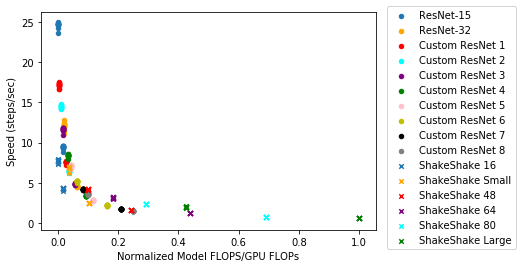

In [94]:
fig, ax = plt.subplots()
ax = res15.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='ResNet-15')
ax = res32.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='ResNet-32',color='orange')
ax = cus1.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='Custom ResNet 1',color='red')
ax = cus2.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='Custom ResNet 2',color='cyan')
ax = cus3.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='Custom ResNet 3',color='purple')
ax = cus4.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='Custom ResNet 4',color='g')
ax = cus5.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='Custom ResNet 5',color='pink')
ax = cus6.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='Custom ResNet 6',color='y')
ax = cus7.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='Custom ResNet 7',color='k')
ax = cus8.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='Custom ResNet 8',color='gray')
ax = shake16.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='ShakeShake 16',marker='x')
ax = shakesmall.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='ShakeShake Small',marker='x',color='orange')
ax = shake48.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='ShakeShake 48',marker='x',color='red')
ax = shakemid.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='ShakeShake 64',marker='x',color='purple')
ax = shake80.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='ShakeShake 80',marker='x',color='cyan')
ax = shakebig.plot.scatter(ax=ax, y="Speed (steps/sec)",x="Model/GPU", label='ShakeShake Large',marker='x',color='g')
plt.legend(bbox_to_anchor=(1.02, 1.05))
plt.xlabel("Normalized Model FLOPS/GPU FLOPs")
plt.show()

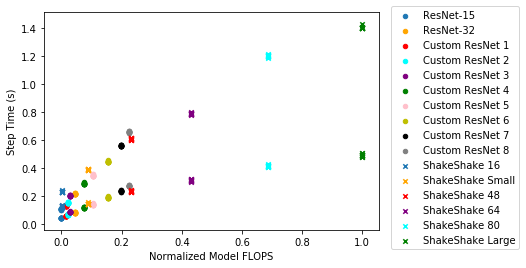

In [72]:
fig, ax = plt.subplots()
ax = res15.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='ResNet-15')
ax = res32.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='ResNet-32',color='orange')
ax = cus1.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='Custom ResNet 1',color='red')
ax = cus2.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='Custom ResNet 2',color='cyan')
ax = cus3.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='Custom ResNet 3',color='purple')
ax = cus4.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='Custom ResNet 4',color='g')
ax = cus5.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='Custom ResNet 5',color='pink')
ax = cus6.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='Custom ResNet 6',color='y')
ax = cus7.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='Custom ResNet 7',color='k')
ax = cus8.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='Custom ResNet 8',color='gray')
ax = shake16.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='ShakeShake 16',marker='x')
ax = shakesmall.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='ShakeShake Small',marker='x',color='orange')
ax = shake48.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='ShakeShake 48',marker='x',color='red')
ax = shakemid.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='ShakeShake 64',marker='x',color='purple')
ax = shake80.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='ShakeShake 80',marker='x',color='cyan')
ax = shakebig.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model FLOPS", label='ShakeShake Large',marker='x',color='g')
plt.legend(bbox_to_anchor=(1.02, 1.05))
plt.show()

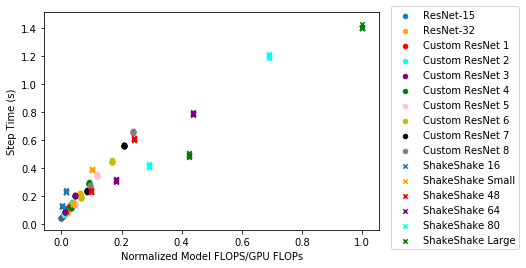

In [73]:
fig, ax = plt.subplots()
ax = res15.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='ResNet-15')
ax = res32.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='ResNet-32',color='orange')
ax = cus1.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='Custom ResNet 1',color='red')
ax = cus2.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='Custom ResNet 2',color='cyan')
ax = cus3.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='Custom ResNet 3',color='purple')
ax = cus4.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='Custom ResNet 4',color='g')
ax = cus5.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='Custom ResNet 5',color='pink')
ax = cus6.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='Custom ResNet 6',color='y')
ax = cus7.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='Custom ResNet 7',color='k')
ax = cus8.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='Custom ResNet 8',color='gray')
ax = shake16.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='ShakeShake 16',marker='x')
ax = shakesmall.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='ShakeShake Small',marker='x',color='orange')
ax = shake48.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='ShakeShake 48',marker='x',color='red')
ax = shakemid.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='ShakeShake 64',marker='x',color='purple')
ax = shake80.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='ShakeShake 80',marker='x',color='cyan')
ax = shakebig.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU", label='ShakeShake Large',marker='x',color='g')
plt.legend(bbox_to_anchor=(1.02, 1.05))
plt.xlabel("Normalized Model FLOPS/GPU FLOPs")
plt.show()

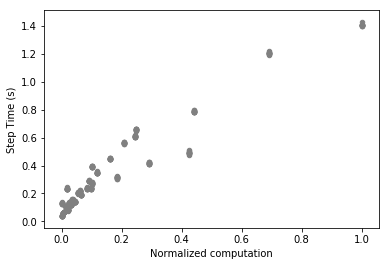

In [8]:
fig, ax = plt.subplots()
ax = k80.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU",marker='o')
ax = p100.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU",marker='o')
plt.xlabel('Normalized computation')
fig.savefig("/Users/ozymandias/Desktop/speed_computation_correlation.pdf", bbox_inches='tight')

In [8]:
###### Below is MAE on the whole K80 trainig + test dataset

In [28]:
data = pd.read_csv('/Users/ozymandias/desktop/experiment_results/speed_data/0latency_k80_new.csv')
data = shuffle(data, random_state=0)

In [11]:
pd.options.display.max_rows = 4000
X = data[['Normalized Model']]
y = data[['Step Time (s)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print scores
print("MAE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print scores
print("MSE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='r2')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
y_pred = regressor.predict(X_test)
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred)) 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[-0.06525863 -0.06037443 -0.06640429 -0.05692951 -0.0736181  -0.06577227
 -0.06178893 -0.06116233 -0.06058666 -0.08018735]
MAE: -0.065 (+/- 0.013)
[-0.0053252  -0.00533981 -0.00551801 -0.00398149 -0.00886047 -0.00537251
 -0.00614171 -0.00550487 -0.00461455 -0.00855416]
MSE: -0.006 (+/- 0.003)
[0.90988518 0.9339844  0.91189591 0.9647782  0.94069771 0.95558373
 0.93717707 0.95565203 0.94920782 0.93534243]
Accuracy: 0.94 (+/- 0.03)
('Mean Absolute Percentage Error:', 19.06311939723701)
('Mean Absolute Error:', 0.06804723659210997)
('Mean Squared Error:', 0.006827285149118072)
('Root Mean Squared Error:', 0.0826273874034395)


In [30]:
X = data[['Normalized Model']]
y = data[['Step Time (s)']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print np.mean(y_test)
svr = SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=0.01, coef0=1)
# svr = SVR(kernel='rbf', C=100, gamma='auto', epsilon=0.01)
svr.fit(X_train, y_train)
scores = cross_val_score(svr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print scores
print("MAE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(svr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print scores
print("MSE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(svr, X_train, y_train, cv=10, scoring='r2')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
y_pred = svr.predict(X_test)
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred)) 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
clf = SVR(kernel='rbf')
grid_values = {'C':[10, 15, 20, 25, 45, 50, 100], 'epsilon':[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]}
grid = GridSearchCV(clf, param_grid = grid_values, scoring='neg_mean_absolute_error', cv=10, n_jobs=1)
from datetime import datetime
grid.fit(X_train,y_train)
print grid.best_params_

0.5780751596423077
[-0.02404118 -0.03872674 -0.02770227 -0.04004841 -0.04585123 -0.03418457
 -0.04383027 -0.03778133 -0.03017485 -0.02785049]
MAE: -0.035 (+/- 0.014)
[-0.00129674 -0.00333919 -0.00171947 -0.00368648 -0.00427195 -0.00254023
 -0.003802   -0.0033497  -0.0025581  -0.00202714]
MSE: -0.003 (+/- 0.002)
[0.97805619 0.95871788 0.97254588 0.96738798 0.97140823 0.97899907
 0.96110972 0.97301434 0.97184311 0.98467766]
Accuracy: 0.97 (+/- 0.02)
('Mean Absolute Percentage Error:', 9.958391599038196)
('Mean Absolute Error:', 0.041030346724748416)
('Mean Squared Error:', 0.003339401035241667)
('Root Mean Squared Error:', 0.05778755086730763)
{'epsilon': 0.01, 'C': 100}


In [20]:
###### Below is MAE on the whole P100 trainig + test dataset dataset

In [26]:
data = pd.read_csv('/Users/ozymandias/desktop/experiment_results/speed_data/0latency_p100_new2.csv')
data = shuffle(data, random_state=0)

In [15]:
X = data[['Normalized Model']]
y = data[['Step Time (s)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print scores
print("MAE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print scores
print("MSE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='r2')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
y_pred = regressor.predict(X_test)
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred)) 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[-0.02756044 -0.03022367 -0.03052395 -0.02798758 -0.03144438 -0.02612006
 -0.02719025 -0.02361825 -0.02691852 -0.03879931]
MAE: -0.029 (+/- 0.008)
[-0.00112872 -0.00114486 -0.00125734 -0.00099549 -0.00158076 -0.00103434
 -0.0013718  -0.00081447 -0.00102941 -0.00181139]
MSE: -0.001 (+/- 0.001)
[0.85225509 0.88343953 0.84381372 0.92450829 0.91337565 0.92540051
 0.87212286 0.94560392 0.91153095 0.89283957]
Accuracy: 0.90 (+/- 0.06)
('Mean Absolute Percentage Error:', 22.27509452413568)
('Mean Absolute Error:', 0.031008214133226977)
('Mean Squared Error:', 0.0014763111405842856)
('Root Mean Squared Error:', 0.038422794544180225)


In [27]:
X = data[['Normalized Model']]
y = data[['Step Time (s)']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
svr = SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=0.01, coef0=1)
# svr = SVR(kernel='rbf', C=100, gamma='auto', epsilon=0.01)
svr.fit(X_train, y_train)
scores = cross_val_score(svr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print scores
print("MAE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(svr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print scores
print("MSE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(svr, X_train, y_train, cv=10, scoring='r2')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
y_pred = svr.predict(X_test)
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred)) 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
clf = SVR(kernel='rbf')
# clf = SVR(kernel='poly',degree=2)
grid_values = {'C':[10, 15, 20, 25, 45, 50, 100], 'epsilon':[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]}
grid = GridSearchCV(clf, param_grid = grid_values, scoring='neg_mean_absolute_error', cv=10, n_jobs=1)
from datetime import datetime
grid.fit(X_train,y_train)
print grid.best_params_

[-0.01590888 -0.02127029 -0.01882619 -0.02448584 -0.02161794 -0.02017631
 -0.02223293 -0.01254686 -0.01542428 -0.01967028]
MAE: -0.019 (+/- 0.007)
[-0.00039954 -0.00081923 -0.0006356  -0.00096189 -0.00066829 -0.00059686
 -0.0008036  -0.00023702 -0.00033522 -0.00049052]
MSE: -0.001 (+/- 0.000)
[0.94770175 0.91659208 0.92104556 0.92705623 0.96337812 0.95695252
 0.92508996 0.98417037 0.97119034 0.97098152]
Accuracy: 0.95 (+/- 0.05)
('Mean Absolute Percentage Error:', 13.786600859787146)
('Mean Absolute Error:', 0.020436785777666118)
('Mean Squared Error:', 0.0007176525492167424)
('Root Mean Squared Error:', 0.026789037855375515)
{'epsilon': 0.01, 'C': 100}


In [2]:
##### Speed vs. model complexity

In [22]:
k80 = pd.read_csv('/Users/ozymandias/desktop/experiment_results/speed_data/0latency_k80_new.csv')
p100 = pd.read_csv('/Users/ozymandias/desktop/experiment_results/speed_data/0latency_p100_new2.csv')
k80 = shuffle(k80, random_state=0)
p100 = shuffle(p100, random_state=0)
# print data
# data.set_index(["GPU (temp)"], inplace=True)

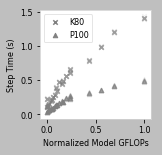

In [41]:
fig, ax = plt.subplots(figsize=(2,2))
font = gen_font('light',8)
ax = k80.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model", label='K80',marker='x',alpha=0.1)
ax = p100.plot.scatter(ax=ax, y="Step Time (s)",x="Normalized Model", label='P100',marker='^',alpha=0.1)
leg = plt.legend(prop=font, framealpha=0.5)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.setp(ax.spines.values(), color='lightgray')
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
plt.xlabel('Normalized Model GFLOPs', fontproperties=font)
plt.ylabel('Step Time (s)', fontproperties=font)
fig.savefig("/Users/ozymandias/Desktop/speed_complexity_correlation.pdf", bbox_inches='tight')

In [23]:
data = pd.read_csv('/Users/ozymandias/desktop/experiment_results/speed_data/0latency_norm_computation.csv')

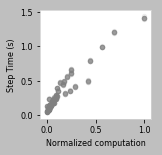

In [31]:
fig, ax = plt.subplots(figsize=(2,2))
ax = data.plot.scatter(ax=ax, y="Step Time (s)",x="Model/GPU",marker='o',alpha=0.1)
font = gen_font('light',8)
# plt.legend(fontsize=8)
plt.setp(ax.spines.values(), color='lightgray')
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
plt.xlabel('Normalized computation', fontproperties=font)
plt.ylabel('Step Time (s)', fontproperties=font)
fig.savefig("/Users/ozymandias/Desktop/speed_computation_correlation.pdf", bbox_inches='tight')

In [4]:
##### GPU agnostic prediction

In [17]:
data = pd.read_csv('/Users/ozymandias/desktop/experiment_results/speed_data/0latency_norm_computation.csv')
data = shuffle(data, random_state=0)

In [18]:
X = data[['Model/GPU']]
y = data[['Step Time (s)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print scores
print("MAE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print scores
print("MSE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='r2')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
y_pred = regressor.predict(X_test)
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred)) 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[-0.08400335 -0.06191125 -0.05872063 -0.06441675 -0.07619531 -0.06964492
 -0.08051274 -0.07481633 -0.07379155 -0.07385781]
MAE: -0.072 (+/- 0.015)
[-0.01067984 -0.0063892  -0.0053367  -0.00654149 -0.00986099 -0.00790763
 -0.00919162 -0.00875387 -0.00773671 -0.00765363]
MSE: -0.008 (+/- 0.003)
[0.88249306 0.92823202 0.91568044 0.94288764 0.87969764 0.91091879
 0.90403876 0.91898304 0.91741794 0.94141315]
Accuracy: 0.91 (+/- 0.04)
('Mean Absolute Percentage Error:', 38.24394455580784)
('Mean Absolute Error:', 0.06801100856621344)
('Mean Squared Error:', 0.007246033772916531)
('Root Mean Squared Error:', 0.0851236381560171)


In [19]:
X = data[['Normalized Model','GPU TFLOPS']]
y = data[['Step Time (s)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print scores
print("MAE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print scores
print("MSE: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring='r2')
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
y_pred = regressor.predict(X_test)
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred)) 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[-0.12599316 -0.11216611 -0.08607815 -0.10247175 -0.11931118 -0.10123273
 -0.09169994 -0.11059256 -0.08623545 -0.09642034]
MAE: -0.103 (+/- 0.026)
[-0.02791182 -0.01937598 -0.00986657 -0.01669761 -0.02549395 -0.0156711
 -0.01153644 -0.01963938 -0.0115061  -0.01433682]
MSE: -0.017 (+/- 0.011)
[0.69289485 0.78235529 0.84410855 0.85421676 0.68897825 0.82346152
 0.87955874 0.81823775 0.87718336 0.89025477]
Accuracy: 0.82 (+/- 0.14)
('Mean Absolute Percentage Error:', 48.17515172135452)
('Mean Absolute Error:', 0.09321478882375701)
('Mean Squared Error:', 0.015091473341996146)
('Root Mean Squared Error:', 0.1228473578958707)
